# Tweet Duygu Analizi

Bu notebook, tweet_eval veri seti kullanılarak duygu analizi modelinin eğitilmesi ve değerlendirilmesi için hazırlanmıştır.

In [2]:
# Gerekli kütüphaneleri içe aktar
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import logging

# Logging ayarları
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

c:\Users\uzeyi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Veri Setini Yükle

In [3]:
# Veri setini yükle
logging.info("Veri seti yükleniyor...")
dataset = load_dataset("tweet_eval", "sentiment")
train_data = pd.DataFrame(dataset['train'])
test_data = pd.DataFrame(dataset['test'])

print(f"Eğitim veri seti boyutu: {len(train_data)}")
print(f"Test veri seti boyutu: {len(test_data)}")

2025-06-14 16:50:01,187 - INFO - Veri seti yükleniyor...


Eğitim veri seti boyutu: 45615
Test veri seti boyutu: 12284


## Veri Setini İncele

In [4]:
# Veri setinin ilk birkaç örneğini göster
train_data.head()

,text,label
0,"""QT @user In the original draft of the 7th boo...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2


2025-06-14 16:50:15,181 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-14 16:50:15,198 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


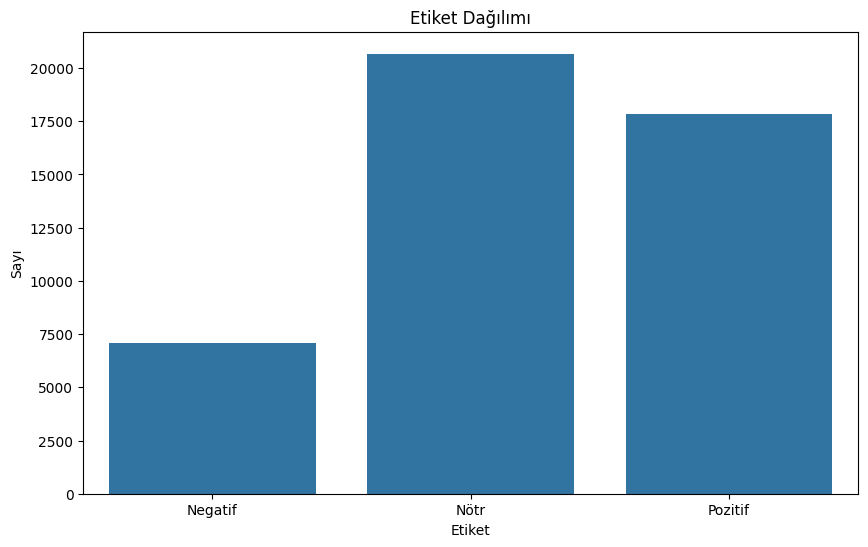

In [5]:
# Etiket dağılımını göster
label_counts = train_data['label'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Etiket Dağılımı')
plt.xlabel('Etiket')
plt.ylabel('Sayı')
plt.xticks([0, 1, 2], ['Negatif', 'Nötr', 'Pozitif'])
plt.show()

## Model Eğitimi

In [6]:
# TF-IDF vektörleştirici oluştur
logging.info("Metinler vektörleştiriliyor...")
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_data['text'])

# Lojistik regresyon modeli oluştur ve eğit
logging.info("Model eğitiliyor...")
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train_tfidf, train_data['label'])

print("Model eğitimi tamamlandı.")

2025-06-14 16:50:15,491 - INFO - Metinler vektörleştiriliyor...
2025-06-14 16:50:17,392 - INFO - Model eğitiliyor...


Model eğitimi tamamlandı.


## Model Değerlendirme

In [7]:
# Test seti üzerinde tahmin yap
logging.info("Test seti üzerinde tahmin yapılıyor...")
X_test_tfidf = vectorizer.transform(test_data['text'])
y_pred = model.predict(X_test_tfidf)

# Sınıflandırma raporu
print("Sınıflandırma Raporu:")
print(classification_report(test_data['label'], y_pred, target_names=['Negatif', 'Nötr', 'Pozitif']))

2025-06-14 16:50:20,795 - INFO - Test seti üzerinde tahmin yapılıyor...


Sınıflandırma Raporu:
              precision    recall  f1-score   support

     Negatif       0.65      0.38      0.48      3972
        Nötr       0.59      0.73      0.66      5937
     Pozitif       0.52      0.58      0.55      2375

    accuracy                           0.59     12284
   macro avg       0.59      0.56      0.56     12284
weighted avg       0.60      0.59      0.58     12284



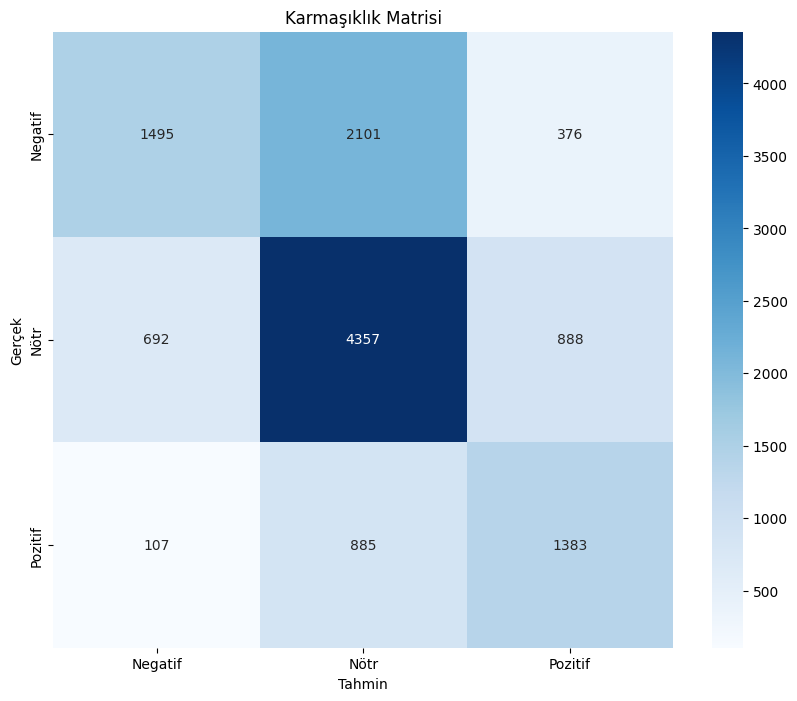

In [8]:
# Karmaşıklık matrisi
cm = confusion_matrix(test_data['label'], y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Nötr', 'Pozitif'],
            yticklabels=['Negatif', 'Nötr', 'Pozitif'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Karmaşıklık Matrisi')
plt.show()

## Örnek Tahminler

In [9]:
# Örnek metinler üzerinde tahmin yap
example_texts = [
    "I love this product! It's amazing!",
    "This is just okay, nothing special.",
    "I hate this product, it's terrible!"
]

for text in example_texts:
    text_tfidf = vectorizer.transform([text])
    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0]
    
    print(f"\nMetin: {text}")
    print(f"Tahmin: {['Negatif', 'Nötr', 'Pozitif'][prediction]}")
    print(f"Olasılıklar: {dict(zip(['Negatif', 'Nötr', 'Pozitif'], probability))}")


Metin: I love this product! It's amazing!
Tahmin: Pozitif
Olasılıklar: {'Negatif': 0.001336252534322186, 'Nötr': 0.0016793617842499368, 'Pozitif': 0.9969843856814279}

Metin: This is just okay, nothing special.
Tahmin: Pozitif
Olasılıklar: {'Negatif': 0.25464288391427675, 'Nötr': 0.2961850120112519, 'Pozitif': 0.4491721040744712}

Metin: I hate this product, it's terrible!
Tahmin: Negatif
Olasılıklar: {'Negatif': 0.9671632753728484, 'Nötr': 0.029314880530840318, 'Pozitif': 0.0035218440963113115}
